In [15]:
import kagglehub
indk214_brain_tumor_dataset_segmentation_and_classification_path = kagglehub.dataset_download('indk214/brain-tumor-dataset-segmentation-and-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'brain-tumor-dataset-segmentation-and-classification' dataset.
Data source import complete.


Import Libraries

In [16]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.metrics import accuracy_score, confusion_matrix

Data Preparation

In [17]:
train_dir = indk214_brain_tumor_dataset_segmentation_and_classification_path + '/DATASET/classification/Training/'
test_dir  = indk214_brain_tumor_dataset_segmentation_and_classification_path + '/DATASET/classification/Testing/'
classes = ['glioma','meningioma','pituitary','notumor']
RED_IMG_SIZE = 128
seed = 99
tf.random.set_seed(seed)
np.random.seed(seed)


 Create DataFrame with file paths and labels

In [18]:
def generate_dataframe(dir):
    data = {'file_path': [], 'label': []}
    for cls in classes:
        class_dir = os.path.join(dir, cls)
        for f in os.listdir(class_dir):
            data['file_path'].append(os.path.join(class_dir, f))
            data['label'].append(cls)
    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

In [19]:
train_df = generate_dataframe(train_dir)
test_df = generate_dataframe(test_dir)

EDA

In [20]:
print("Train set info:")
print(train_df.info())

Train set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  5712 non-null   object
 1   label      5712 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB
None


In [21]:
print("\nTest set info:")
print(test_df.info())


Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  1311 non-null   object
 1   label      1311 non-null   object
dtypes: object(2)
memory usage: 20.6+ KB
None


In [22]:
print("\nMissing values in train:", train_df.isna().sum().sum())


Missing values in train: 0


In [23]:
print("Missing values in test:", test_df.isna().sum().sum())

Missing values in test: 0


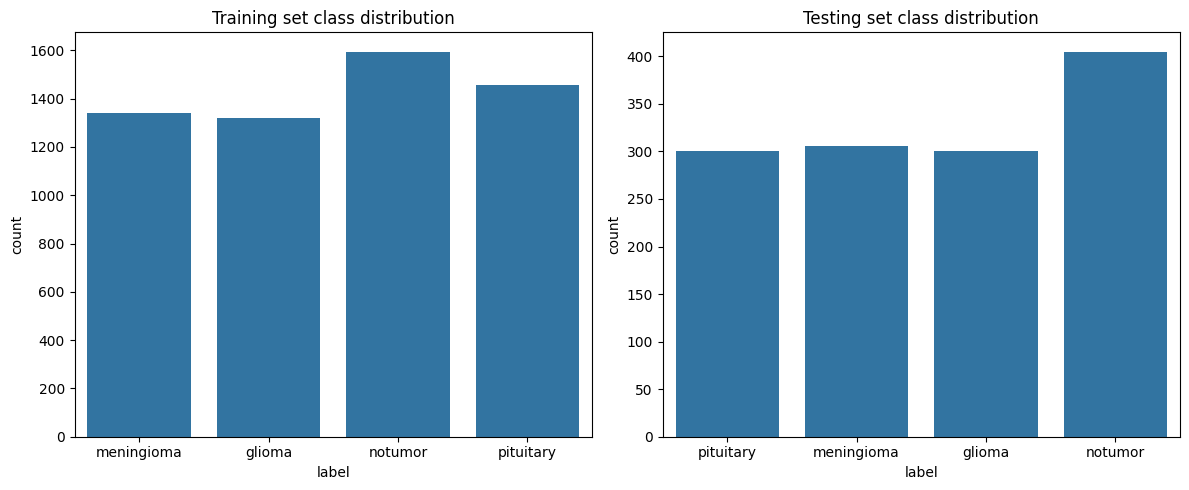

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x='label', data=train_df)
plt.title('Training set class distribution')
plt.subplot(1,2,2)
sns.countplot(x='label', data=test_df)
plt.title('Testing set class distribution')
plt.tight_layout()
plt.show()

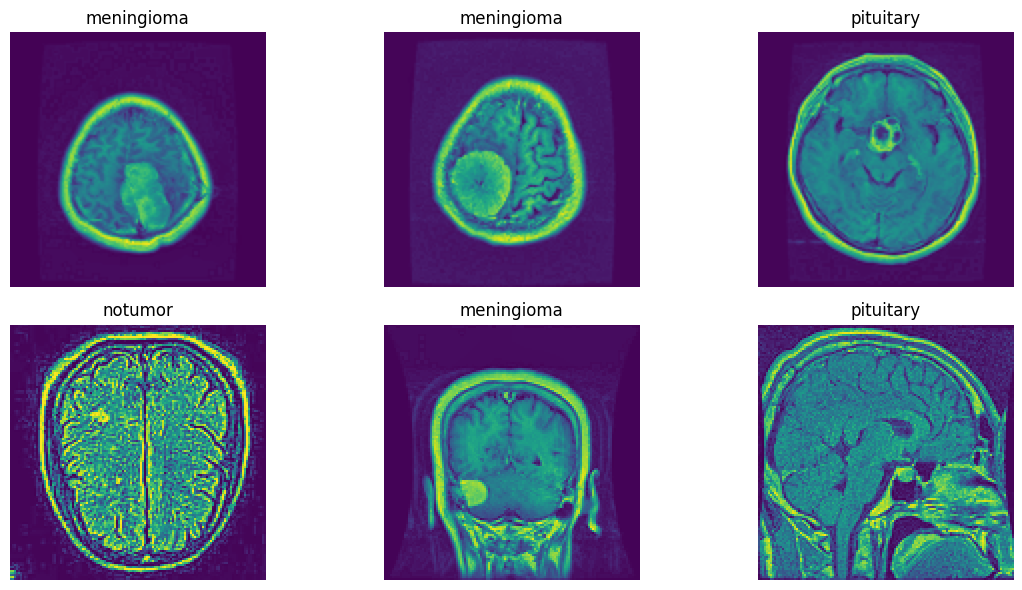

In [25]:
from PIL import Image

sample_indices = random.sample(range(len(train_df)), 6)
plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_indices):
    img = Image.open(train_df.file_path[idx]).resize((128,128))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(train_df.label[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

One-hot encoding

In [26]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.label).astype(int)[classes]], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df.label).astype(int)[classes]], axis=1)

In [27]:
train_paths = train_df.file_path.tolist()
train_labels = train_df[classes].values
test_paths = test_df.file_path.tolist()
test_labels = test_df[classes].values

Data Augmentation + Dataset preparation1

In [28]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    if tf.random.uniform([]) > 0.5:
        image = tf.image.rot90(image, k=tf.random.uniform([],1,4,dtype=tf.int32))
    return image

def load_and_preprocess_image(path, label, training=True):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [RED_IMG_SIZE, RED_IMG_SIZE])
    image = tf.cast(image, tf.float32)/255.0
    if training:
        image = augment_image(image)
    return image, label


In [29]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(lambda x, y: load_and_preprocess_image(x, y, training=True),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(lambda x, y: load_and_preprocess_image(x, y, training=False),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
